# **anaKrys**

(*version 2022.6.0*)

**notebook settings & imports  (edit %matplotlib magic here)**

In [1]:
# set %matplotlib inline (%matplotlib widget, %matplotlib qt) for static (interactive on-page, interactive in separate window) plots
# in order to use the on-page interactive mode, make sure the environment is set up properly
# comment this out before exporting the notebook to a Python script -- via jupyter nbconvert --to script anaKrys.ipynb
%matplotlib inline

# external modules
import datetime
import importlib
import os
import pickle
import succolib as sl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

# internal modules (in .modules)
from modules import *

**starting chronometer**

In [2]:
tStart = datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp())  # start chronometer
tStartPrint = tStart.strftime("%Y-%m-%d %H:%M:%S GMT")
print("%s --> let's start!" % tStartPrint)
print("--")

2022-06-08 17:52:40 GMT --> let's start!
--


---

## **input settings**

In [3]:
# data reload controller -- if True (False), reload the data files (use the dataframe already in memory)
boolLoad = True

# progressbar visualisation controller -- if True (False) the file opening progressbars will (not) be visualised
# in particular, set it to False if working in an environment with no widgets enabled
bProgressBars = False

# test mode controller: if True (False), the software runs with test (custom, selected via settingsFileMods) settings and data
boolTest = False

# run numbers or types to be opened
# format: list of strings -- insert run numbers or types as they appear in nRun0
# might be left empty in test mode -- both test runs "test0" & "test1" selected by default
nRunToOpen = ["PWOStrip_Axial_e-_2"]

# label of the settings fileset to load -- useless if boolTest=False
settingsFileMods = "y18AxialCernH2"

# filetype, string -- either "ASCII", "NPZ" or "ROOT"
fileType = "ROOT"

# file path (with / at the end), string
# useless in test mode, in which it is set automatically depending on fileType
filePath = os.environ.get("HOME")+"/data_local/18_cern_h2_axial/tree/" if fileType=="ROOT" else os.environ.get("HOME")+"/data_local/18_cern_h2_axial/ascii/"

# file name format (with no path), string
# shape: replace the run number with XXXXXX and (for multiple files per run) the file number with YYYYYY
# useless in test mode, in which it is set automatically depending on fileType
fileNameFormat = "runXXXXXX.root" if fileType=="ROOT" else "runXXXXXX_multi_YYYYYY.dat"

#######################################
# import settings, according to boolTest and settingsFileMods
# function in .modules --> set ./settings/__init__.py for settings fileset selection
mod_runList_name, mod_settings_name = settingsSelect(boolTest, whichInput = fileType if boolTest else settingsFileMods)
globals().update(importlib.import_module(mod_runList_name).__dict__)
globals().update(importlib.import_module(mod_settings_name).__dict__)

#######################################
# print only (functions in .modules)
boolControlPrint(boolLoad, boolTest, fileType)
print("--")
settingsPrint(filePath, fileNameFormat, nRunToOpen, nRun0)  # print only (function in .modules)
print("--")

looking for files with label y18AxialCernH2 in ./settings/
execution control booleans:
data reload controller: True
test mode controller: False
--
will work with run numbers(s)/type(s) in /mnt/c/Users/succo/succo/data_local/18_cern_h2_axial/tree/ with format runXXXXXX.root
(1/1) 300331 PWOStrip_Axial_e-_2
--


---

## **opening the data files**

In [4]:
##############################
# data (re)loading is performed only if required
if boolLoad: 
    
    # default nRunToOpen for test mode
    if boolTest & (len(nRunToOpen)==0):
        nRunToOpen = ["test0", "test1"]  # do not edit this! proper setting above
    
    # some dataset-related info
    filePathTest = "./data_test/ascii_test/" if fileType=="ASCII" else "./data_test/tree_test/"
    fileNameFormatTest = "runXXXXXX_YYYYYY.dat" if fileType=="ASCII" else "runXXXXXX.root"
    fileNameFormatFull = (filePathTest if boolTest else filePath) + (fileNameFormatTest if boolTest else fileNameFormat)  # full filenames, i.e. with path
    nRun = {}  # dictionary of the files to be opened only (same format as nRun0)
    for iRun in nRun0:
        if (iRun in nRunToOpen) | (nRun0[iRun] in nRunToOpen):
            nRun.update({iRun: nRun0[iRun]})
    
    # data opening (function in .modules)
    # recall:
    #      - in ROOT case, remapping is also done
    #      - swapped layers are also mirrored run by run
    #      - iRun & typeRun columns also created (respectively with nRun0 keys & values)
    df, dt = loadGeneral(fileType, fileNameFormatFull, nRun, descFrac, mirrorMap, globals(), bProgressBars)
    print("--")
    
    # newly created df structure info printing
    loadDonePrint(df, dt)  # print only (function in .modules)

##############################
# print already existing df info if not (re)loading any data file
else:  
    loadSkipPrint(df)  # print only (function in .modules)
    
print("--")

opening ROOT files... --> data into DataFrame df
progressbars won't be visualized...
(1/1) 300331 -- descaling fraction: 1.000000000000
remapping some ROOT tree variables (from tree map given)
no variables to mirror
iRun also added to df
--
typeRun added to df
--
done (in 6.18 s) --> raw data have (events, variables) = (1073857, 68)
--


In [5]:
# detect data availability (function in .modules)
# main data: 
#     iStep, epoch, xGonio (any), base xRaw/nHit (4 input, 2 output), digiPHRaw (any), digiTime (same as or less than digiPHRaw)
#     furthermore, PHCaloFwd & EFwd a priori existance is checked -- they are computed from scratch only if False
df, bIStep, bEpoch, bXGonio, bXRaw, bNHit, bDigiPHAny, lsDigiCh, bDigiTime, bPHCaloFwd0, bEFwd0 = dfCheckAvailability(df, baseTrackingMap)
print("--")

# filter out the non-interesting data according to dfFilters (function in .modules)
df = dfFiltering(df, filterMap)
print("--")

# detect unavailable mandatory z entries run by run & set them to 0 (function in .modules)
z = zBaseCheckAvailability(z, df["iRun"].unique(), baseTrackingMap)
print("--")

scan step number (iStep) availability: True 
--
Unix time (epoch) availability: False 
--
goniometer DOF availability: True (5)
xGonioRaw + ['Rot', 'Crad', 'Horsa', 'HorsaBig', 'Versa']
--
input modules should be: ['0', '1', '2', '3']
output modules should be: ['4', '5']
input tracking availability (xRaw...): True
output tracking availability (xRaw...): True
input multiplicity availability (nHit...): True
output multiplicity availability (nHit...): True
--
digitizer channel availability: True
8 channels: digiPHRaw + ['CaloFwd', 'CaloFwdBad', 'CaloLat0', 'CaloLat1', 'CaloLat2', 'CaloLatBad', 'Crys', 'Trig']
8 with time: digiTime + ['CaloFwd', 'CaloFwdBad', 'CaloLat0', 'CaloLat1', 'CaloLat2', 'CaloLatBad', 'Crys', 'Trig']
--
forward calorimeter total signal (PHCaloFwd) availability a priori: False
forward calorimeter total in GeV (EFwd) availability a priori: True
--
keeping xRaw0 in (-20.000000, 20.000000)
keeping xRaw1 in (-20.000000, 20.000000)
keeping xRaw2 in (-20.000000, 20.000000)

## **physics analysis**

### **input tracking**

In [6]:
# input mean multiplicity (function in .modules)
if bNHit["in"]:
    df = aveVar(df, ["nHit"+s for s in baseTrackingMap[0]], "nHitIn")
    
    # also single-hit boolean
    # note: single-hit selection is not based on nHitOut but rather on output layers individually
    df = inHitCuts(df, ["nHit"+s for s in baseTrackingMap[0]])
    
else:
    print("nHitIn & corresponding boolean not added to df")
    
print("--")

nHitIn added to df -- (mean, std) = (1.000000, 0.000000)
boolSingleHitIn added to df
--


In [7]:
# input tracking (functions in .modules)
# recall that (if input positions available) input tracking is done regardless of input multiplicity
#     --> if needed, single-hit selection has to be applied manually a posteriori
if bXRaw["in"]:
    # input angles/aligned tracking info
    # also input angle selection, according to thInCut
    df = trackingAngleAlign(df, ["xRaw"+s for s in baseTrackingMap[0]], thInCentres, "thIn", z, True, thInCut)
    print("--")
    
    # input beam projection @ crystal & @ forward calorimeter
    # also crystal fiducial selection, according to xCryCut
    # also print several input beam info
    df = inputTrackingProj(df, baseTrackingMap[0], z, xCryCut)
    
else:
    print("no input beam info available --> no raw angles, aligned angles, aligned positions & projections added to df")
    
print("--")

run 300331:
thInRaw0 added to df
aligning x layers (xRaw0 & xRaw2) with the value given in the settings: -0.0000646883
thInRaw1 added to df
aligning y layers (xRaw1 & xRaw3) with the value given in the settings: 0.0002440018
boolInAligned: ellipse centered in 0 with hor. (ver.) half-axis 0.000100 (0.000100) (edge excluded)
--
run 300331: boolInCry(0/1): (1.250000 < x < 1.410000) & (0.330000 < y < 1.430000)
--
x axis
final input angle thIn0: (mean, std) = (-0.000001, 0.000100)
final beam projections: x0, x2, xCry0, xCaloFwd0
y axis
final input angle thIn1: (mean, std) = (-0.000002, 0.000090)
final beam projections: x1, x3, xCry1, xCaloFwd1
--


### **goniometer**

In [8]:
# from xGonioRaw... to xGonio... -- according to info in gonioMap (function in .modules)
if bXGonio:
    df = gonioPair(df, gonioMap)
else:
    print("no goniometer info available --> no final goniometer DOF added to df")
    
print("--")

xGonioRawRot paired to thIn0 (as it is in df) with factor 1.000000E+06 --> xGonioRot
xGonioRawCrad paired to thIn1 (as it is in df) with factor 1.000000E+06 --> xGonioCrad
xGonioRawHorsa paired to xCry0 (shifted via its mean) with factor 1.000000E+01 --> xGonioHorsa
xGonioRawHorsaBig paired to xCry0 (shifted via its mean) with factor 1.000000E+01 --> xGonioHorsaBig
xGonioRawVersa paired to xCry1 (shifted via its mean) with factor -1.000000E+01 --> xGonioVersa
--


### **output tracking**

In [9]:
# output mean multiplicity (functions in .modules)
if bNHit["out"]:
    df = aveVar(df, ["nHit"+s for s in baseTrackingMap[1]], "nHitOut")
    
    # also booleans -- single-hit, low multiplicity & high-multiplicity, according to outMultCut
    # note: single-hit selection is not based on nHitOut but rather on output layers individually
    df = outHitCuts(df, ["nHit"+s for s in baseTrackingMap[1]], outMultCut)
    
else:
    print("nHitOut & corresponding booleans not added to df")
    
print("--")

nHitOut added to df -- (mean, std) = (3.376362, 1.834922)
boolSingleHitOut added to df
--
run 300331:
boolLowHitOut: output multiplicity lower window @ <= 1.000000
boolHighHitOut: output multiplicity upper window @ >= 2.000000
--


In [10]:
# output tracking (functions in .modules)
# recall that (if output positions available) output tracking is done regardless of input/output multiplicity
#     --> if needed, single-hit selections have to be applied manually a posteriori
if bXRaw["out"]:
    # for output stage analysis, xCry0-1 = 0 when input tracking is absent
    if not bXRaw["in"]:
        df.loc[:, "xCry%d"%i] = 0
        print("input tracking unavailability --> doing output tracking with xCry0/1 automatically set to 0\n--")
    
    # output angles/aligned tracking info
    df = trackingAngleAlign(df, ["xCry0", "xCry1"] + ["xRaw"+s for s in baseTrackingMap[1]], thOutCentres, "thOut", z, False)
    print("--")
    
    # output-input angle delta
    df = trackingAngleDelta(df)
    
    # print output beam info
    outputTrackingPrint(df, baseTrackingMap[1])
        
else:
    print("no output beam info available --> no raw angles, aligned angles, angle deltas & aligned positions added to df")
    
print("--")

run 300331:
thOutRaw0 added to df
aligning x layers (xCry0 & xRaw4) with the value given in the settings: 0.0065467740
thOutRaw1 added to df
aligning y layers (xCry1 & xRaw5) with the value given in the settings: 0.0056963040
--
x axis
final output angle thOut0: (mean, std) = (-0.003106, 0.063295)
final beam projections: xCry0, x4
output-input angle delta thDelta0: (mean, std) = (-0.003106, 0.063295)
y axis
final output angle thOut1: (mean, std) = (0.001582, 0.042773)
final beam projections: xCry1, x5
output-input angle delta thDelta1: (mean, std) = (0.001584, 0.042773)
--


### **digitizers**

In [11]:
# (various functions in .modules)
# recall that elements of lsDigiCh are available in df (with prefix "digiPHRaw") by definition
# if PHCaloFwd (EFwd) already in df, forward calo. sum (calibration) is not performed -- according to bPHCaloFwd0 (bEFwd0)
#     --> name the raw variable differently to (re)execute this

if (bDigiPHAny | bPHCaloFwd0 | bEFwd0):
    # channels equalisation
    df = equalise(df, lsDigiCh, equalMap)
    print("--")
    
    # PH & time booleans
    df = defineDigiBooleans(df, lsDigiCh, digiPHCut, digiTimeCut, bDigiTime)
    print("--")

    # forward calorimeter total PH
    # behaviour according to bPHCaloFwd0
    # if already existing in df, this is not performed --> name the raw variable differently to (re)execute this
    df, bPHCaloFwd = caloSum(df, bPHCaloFwd0, lsDigiChCaloFwd, "Fwd", False)
    print("--")
    
    # forward calorimeter time boolean (OR between single-channel time booleans)
    # only useful if single channels data are available (regardless of whether or not they have been used to get PHCaloFwd), otherwise always True
    df = caloTimeBool(df, bPHCaloFwd, lsDigiChCaloFwd, bDigiTime, "Fwd")
    print("--")
    
    # forward calorimeter energy in GeV
    # behaviour according to bEFwd0
    # if already existing in df, this is not performed --> name the raw variable differently to (re)execute this
    df, bEFwd = calibrate(df, bEFwd0, calibMapFwd, "Fwd", False)

else:
    bPHCaloFwd = {}
    bEFwd = {}
    print("no digitizer data available --> no equalised PH, PH & time booleans, forward calo. total PH & energy added to df")

print("--")

run 300331:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
--
run 300331:
cuts added to df: boolDigiPH + ['CaloFwd', 'CaloLat0', 'CaloLat1', 'CaloLat2']
cuts added to df: boolDigiTime + ['CaloFwd', 'CaloLat0', 'CaloLat1', 'CaloLat2', 'Crys', 'Trig']
--
run 300331:
PHCaloFwd not already in df --> can be created
PHCaloFwd added to df
--
run 300331:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
--
run 300331:
EFwd already in df with (mean, std) = (54.860463, 39.951788) --> keeping it
--


---

## **plots & output**

In [12]:
# initialising output plots data dictionary -- empty, it will be filled with the objects needed
outData = {}

# initialising units of measurement dictionary -- empty string for all the df variables by default
units = dict(zip(df.columns, ["" for s in df.columns]))

# limiting the selection dictionaries to the runs currently under study
thInCut0 = {k: v for k, v in thInCut.items() if k in df["iRun"].unique()}
xCryCut0 = {k: v for k, v in xCryCut.items() if k in df["iRun"].unique()}
outMultCut0 = {k: v for k, v in outMultCut.items() if k in df["iRun"].unique()}
digiPHCut0 = {k: v for k, v in digiPHCut.items() if k in df["iRun"].unique()}
digiTimeCut0 = {k: v for k, v in digiTimeCut.items() if k in df["iRun"].unique()}

### **plot & output settings (other settings in each plot cell)**

In [13]:
# if True (False), base plots and related fits are (not) created
boolPlotGlob = True

# units -- dictionary of the units of measurement for plots
# shape: {var: unit} (all string)
# unit format: unit between brackets
# all the missing variable units are automatically set to empty strings (above)
units.update({"epoch": "[s]"})
units.update({"xGonioRot": "[urad]"})
units.update({"xGonioCrad": "[urad]"})
units.update({"xGonioHorsa": "[mm]"})
units.update({"xGonioHorsaBig": "[mm]"})
units.update({"xGonioVersa": "[mm/2]"})
units.update({"EFwd": "[GeV]"})
units.update({"x"+baseTrackingMap[0][0]: "[cm]"})
units.update({"x"+baseTrackingMap[0][1]: "[cm]"})
units.update({"xCry0": "[cm]"})
units.update({"xCry1": "[cm]"})
for iCh in [s for s in df.columns if "digiPH" in s]:
    units.update({iCh: "[ADC]"})
for iCh in [s for s in df.columns if "digiTime" in s]:
    units.update({iCh: "[ADC]"})
for iTh in [s for s in df.columns if ("thIn" in s) | ("thOut" in s)]:
    units.update({iTh: "[rad]"})

# other graphic settings
pal2d = "viridis"  # palette for 2d plots
lineC = "0.7"  # color of plot patches (e.g. selection ranges) lines
fitC = "0.1" # color of fit lines
lineW = 1.5  # width of plot patches (e.g. selection ranges) lines
fitW = 1.5  # width of fit lines

# if True (False), figures are (not) saved in ./out_plots
# this is particularly important when running the software as a Python script
bPlotSave = True

# also recall to set boolPlotGlob above, in the input settings section

### **run base info**

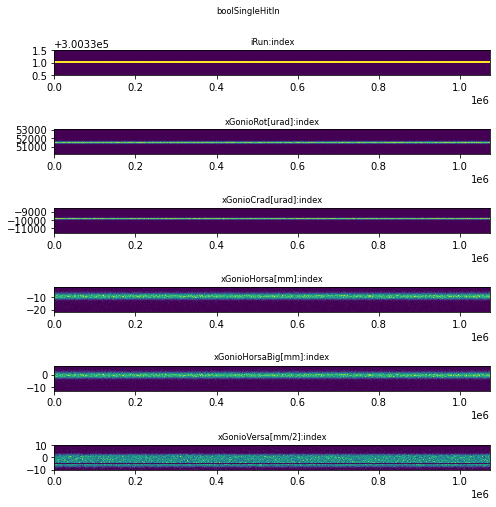

In [14]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = "runInfo"  # figure name
xSize = 7  # horizontal figure size
ySize = 7  # vertical figure size
bUseEpoch = False  # if True (False) the epoch (automatic event index) is used -- only if epoch in df, otherwise event index anyway

###############
if boolPlotLoc & boolPlotGlob:
    ax = plot_runInfo(df, ["boolSingleHitIn"] if bNHit["in"] else [], bXGonio, bEpoch, bUseEpoch, pal2d, units, xSize, ySize, figName, bPlotSave)
    # if input multiplicity is available, base info are studied in input single hit condition
    # this is always drawn, since at least iRun is always created inside df -- goniometer DOF availability checked inside the function

### TRACKING **input beam profiles & spot**

x0 spectrum returned in a dictionary with key x0_histo -- x, y, ey
stats:
	mean			1.305181
	FWHM range centre	1.320000
	FWHM			0.310000
==> returned in a dictionary with key x0_stat -- mean, FWHM range centre, FWHM
--
x1 spectrum returned in a dictionary with key x1_histo -- x, y, ey
stats:
	mean			0.858610
	FWHM range centre	0.870000
	FWHM			0.810000
==> returned in a dictionary with key x1_stat -- mean, FWHM range centre, FWHM
--


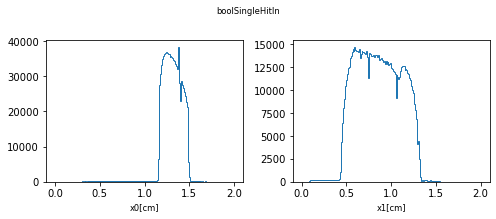

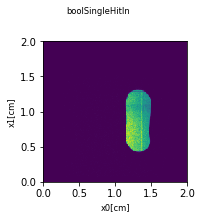

In [15]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = "xIn"  # figure name -- the part "_1d"/"_2d" will be appended
xSize = [7, 3]  # horizontal figure size -- 1d-then-2d
ySize = [3, 3]  # vertical figure size -- 1d-then-2d
binSize = [0.01, 0.01]  # bin size, same for x & y in all the plots below -- 1d-then-2d -- if a component is None, it is automatically computed
hRange = [[0, 2], [0, 2]]  # axes ranges, same in all the plots below -- format [[x0, x1] or None, [y0, y1] or None] (if None, automatic definition)
bLog = False  # if True (False), log (lin) scale on z
bPlot2d = True  # if True (False), 2d profile plot is (not) plotted
lsBool = ["boolSingleHitIn"]  # list of booleans (available in df) to be applied to all the plots here

###############
if boolPlotLoc & boolPlotGlob & bXRaw["in"]:
    outData = plot_prof(df, ("x"+baseTrackingMap[0][0], "x"+baseTrackingMap[0][1]), binSize[0], lsBool, hRange, outData, bLog, units, xSize[0], ySize[0], figName+"1d", bPlotSave)
    if bPlot2d:
        plot_proj(df, ("x"+baseTrackingMap[0][0], "x"+baseTrackingMap[0][1]), binSize[1], lsBool, hRange, False, {}, bLog, lineC, lineW, pal2d, units, xSize[1], ySize[1], figName+"2d", bPlotSave)

# outData is updated with bin-by-bin spectra values & fit parameters -- entries "thIn/OutN_histo/fit"

### TRACKING **angles**

spectrum returned in a dictionary with key thIn0_histo -- x, y, ey
performing gaussian fit on thIn0...
fit parameters:
	ampl.	9.897140e+04 +- 4.667670e+06
	mean	3.374969e-07 +- 2.172733e-12
	sigma	8.367975e-05 +- 1.205265e-12
fit parameters are returned in a dictionary with key thIn0 -- parameters, cov. matrix_fit
--
spectrum returned in a dictionary with key thIn1_histo -- x, y, ey
performing gaussian fit on thIn1...
fit parameters:
	ampl.	1.277648e+05 +- 6.914182e+06
	mean	-3.476246e-07 +- 1.132917e-12
	sigma	6.503067e-05 +- 6.587503e-13
fit parameters are returned in a dictionary with key thIn1 -- parameters, cov. matrix_fit
--
spectrum returned in a dictionary with key thOut0_histo -- x, y, ey
performing gaussian fit on thOut0...
fit parameters:
	ampl.	1.238035e+04 +- 2.215686e+05
	mean	-1.025803e-06 +- 1.185482e-11
	sigma	1.110229e-04 +- 6.362084e-12
fit parameters are returned in a dictionary with key thOut0 -- parameters, cov. matrix_fit
--
spectrum returned in a dictionary with

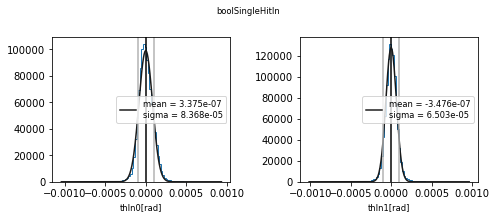

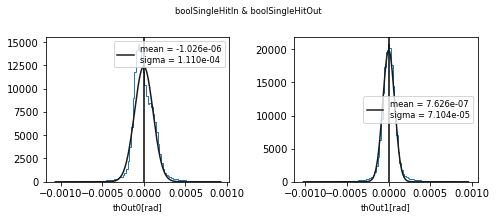

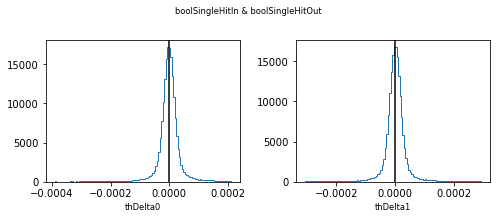

In [16]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = ["thIn", "thOut", "thDelta"]  # figure names -- in-then-out-then-delta
xSize = 7  # horizontal figure size
ySize = 3  # vertical figure size
xRange = [[-0.001, 0.001], [-0.001, 0.001], [-0.0003, 0.0003]]  # plot ranges, in-then-out-then-delta -- for each, left-then-right, same for x & y -- values can be None (i.e. automatic definition)
binSize = [0.00002, 0.00002, 0.000005]  # bin sizes -- in-then-out-then-delta -- if a value is None, automatically computed
bFit = [True, True, False]  # do fits if True -- in-then-out-then-delta
fitSigma = [0.0001, 0.0001, 0.0001]  # starting point for sigma fits (set to ~ half the distribution FWHM or None, i.e. automatic computation) -- in-then-out-then-delta, only used if bFit=True
bSel = True  # draw input selection according to thInCut -- only for input
bLog = False  # if True (False), log (lin) scale on y

###############
lsBool = [[], [], []]
if bNHit["in"]:
    lsBool[0].append("boolSingleHitIn")
    lsBool[1].append("boolSingleHitIn")
    lsBool[2].append("boolSingleHitIn")
if bNHit["out"]:
    lsBool[1].append("boolSingleHitOut")
    lsBool[2].append("boolSingleHitOut")
# if input/input-output multiplicity is available, input/output & delta angle distr. are studied in input/input-output single hit condition

if boolPlotLoc & boolPlotGlob:
    if bXRaw["in"]:
        outData = plot_th(df, "thIn", binSize[0], lsBool[0], xRange[0], bFit[0], fitSigma[0], outData, bSel, thInCut0, bLog, fitC, fitW, lineC, lineW, units, xSize, ySize, figName[0], bPlotSave)
    if bXRaw["out"]:
        # recall that output angles are computed even in absence of input tracking data -- hits @ crystal automatically set to (0, 0, 0)
        outData = plot_th(df, "thOut", binSize[1], lsBool[1], xRange[1], bFit[1], fitSigma[1], outData, False, {}, bLog, fitC, fitW, lineC, lineW, units, xSize, ySize, figName[1], bPlotSave)
    if bXRaw["in"] & bXRaw["out"]:
        outData = plot_th(df, "thDelta", binSize[2], lsBool[2], xRange[2], bFit[2], fitSigma[2], outData, False, {}, bLog, fitC, fitW, lineC, lineW, units, xSize, ySize, figName[2], bPlotSave)
        
# outData is updated with bin-by-bin spectra values & fit parameters -- entries "thIn/OutN_histo/fit"

### TRACKING **multiplicities**

2d spectrum returned in a dictionary with key nHitOut_index_histo -- x, y, z
--
studying nHitOut when iRun = 300331
1d spectrum returned in a dictionary with key nHitOut_300331_histo -- x, y, ey
--


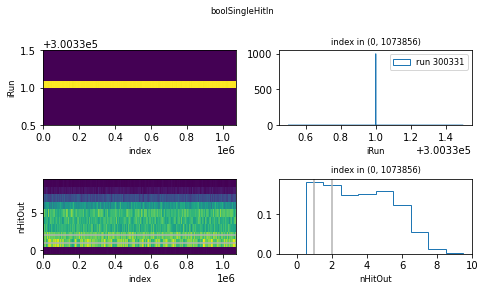

In [17]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = "nHitOut"  # figure name
xSize = 7  # horizontal figure size
ySize = 4  # vertical figure size
bUseEpoch = False  # if True (False) the epoch (automatic event index) is used -- only if epoch in df, otherwise event index anyway
maxNHit = 10  # multiplicity upper limit -- if None, range (& binning) automatically defined
bSel = True  # draw output selection according to outMultCut -- only for output
tRange = None  # range on the 2d plots x to be used to costrain the data included in the 1d plots -- length-2 array or None (for no costraint)
bLog = False  # if True (False), log (lin) scale on y/z in 1d/2d plots

###############
if boolPlotLoc & boolPlotGlob & bNHit["out"]:
    outData = plot_nHit(df, "nHitOut", ["boolSingleHitIn"] if bNHit["in"] else [], bEpoch, bUseEpoch, maxNHit, tRange, bSel, outMultCut0, outData, bLog, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)
    # if input multiplicity is available, output multiplicity is studied in input single hit condition
    
# outData is updated with bin-by-bin spectra values (2d & 1d) -- entries "nHitOut_nameX_histo" (2d) & "nHitOut_iRun_histo" (1d)

### TRACKING **beam spots @ crystal**

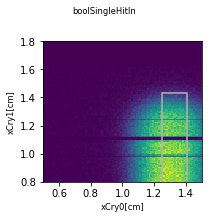

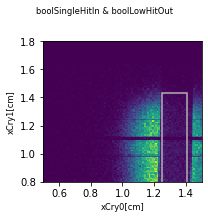

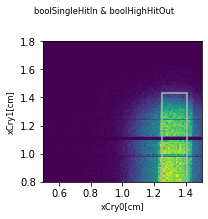

In [18]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = "xCry"  # figure name
xSize = 3  # horizontal figure size
ySize = 3  # vertical figure size
binSize = 0.01  # bin size, same for x & y in all the plots below -- if None, automatically computed
hRange = [[0.5, 1.5], [0.8, 1.8]]  # axes ranges, same in all the plots below -- format [[x0, x1] or None, [y0, y1] or None] (if None, automatic definition)
bSel = [True, True]  # draw fiducial selection according to xCryCut -- plot without multiplicity cut, then plots with multiplicity cut
bLog = False  # if True (False), log (lin) scale on z

###############
lsBool0 = ["boolSingleHitIn"] if bNHit["in"] else []
# if input multiplicity is available, beam projections @ crystal are studied in input single hit condition

if boolPlotLoc & boolPlotGlob & bXRaw["in"]:
    plot_proj(df, "xCry", binSize, lsBool0+[], hRange, bSel[0], xCryCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)
    if bNHit["out"]:
        # furthermore, study with different output multiplicity selection performed only if output multiplicity data available
        plot_proj(df, "xCry", binSize, lsBool0+["boolLowHitOut"], hRange, bSel[1], xCryCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, "xCry_lowHitOut", bPlotSave)
        plot_proj(df, "xCry", binSize, lsBool0+["boolHighHitOut"], hRange, bSel[1], xCryCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, "xCry_highHitOut", bPlotSave)

### GONIOMETER **2d phase space**

In [19]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "gonioPhaseSpace"  # figure name
xSize = 4  # horizontal figure size
ySize = 4  # vertical figure size
lsVar = ["Rot", "Crad"]  # length-2 list of gonio. variables to be plot (x-then-y) -- names without the prefix xGonio
lsBool = ["boolInCry"]  # list of booleans (available in df) to be applied -- input single hit condition applied automatically (if data available)
bLog = False  # if True (False), log (lin) scale on z

###############
lsBool0 = ["boolSingleHitIn"] if bNHit["in"] else []
# if input multiplicity is available, goniometer DOF phase space is studied in input single hit condition

if boolPlotLoc & boolPlotGlob & bXGonio:
    plot_gonioCorr(df, lsVar, lsBool0+lsBool, bLog, pal2d, units, xSize, ySize, figName, bPlotSave)

### GONIOMETER **trends over other variables**

In [20]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "gonioTrends"  # figure name base -- it will be completed with "_" and the name of each variable under study
xSize = 7  # horizontal figure size (for each single figures)
ySize = 4  # vertical figure size (for each single figures)
lsBool = ["boolInAligned", "boolInCry"]  # list of booleans (available in df) to be applied to all the plots here -- input single hit cond. applied automatically (if data available)
bLog = False  # if True (False), log (lin) scale on z

# dictionary of the variables to be analysed -- shape:
# {varY (string): {
#         varX0 (string): [[xL0, xR0, dx0], [yL0, yR0, dy0], [bDrawProf0 (bool), bFit0 (bool), deg0 (integer), xFitL0, xFitR0]], (float if not otherwise specified)
#         varX1: [[xL1, xR1, dx1], [yL1, yR1, dy1], [bDrawProf1, bFit1, deg1, xFitL1, xFitR1]],
#         ...
# }}
# 1 figure per varY, each with 1 plot per varX -- varX format: part of the variable name following "xGonioRaw"
# plot in ranges (xL, xR) & (yL, yR) with bin size dx & dy
# profile plot polynomial fit with degree deg -- supported deg = 0, 1, 2; also Gaussian fit if deg = "Gaussian"
# all entries (apart from bFit) can also be None -- automatic definition in this case (e.g. deg = 0)
dictGonioTrends = {
    "nHitOut": {
        "Rot": [[None, None, None], [None, None, 1], [True, True, 2, None, None]],
    },
}
        
###############
lsBool0 = ["boolSingleHitIn"] if bNHit["in"] else []
# if input multiplicity is available, goniometer trends are studied in input single hit condition

if boolPlotLoc & boolPlotGlob & bXGonio:
    for i, iY in enumerate(dictGonioTrends):
        outData = plot_gonioTrends(df, iY, dictGonioTrends[iY], lsBool0+lsBool, outData, bLog, fitC, fitW, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)
        
# outData is updated with profile plots & fit info (only if fit requested) -- entries name format: "nameY_nameX_prof" & "nameY_nameX_fit"

### DIGITIZERS **single-channel PH-vs-time phase spaces**

In [21]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "digi"  # figure name
xSize = 7  # horizontal figure size
ySize = 14  # vertical figure size
lsBool = []  # list of booleans (available in df) to be applied -- same for all the channels (if using cuts on crystal, consider including input single hit cond.)
binSize = [8, 4]  # bin sizes -- time-then-PH -- if a value is None, automatically computed
bSel = True  # draw PH & time selection boxes according to digiPHCut & digiTimeCut -- same boolean for all the digitizer channels
bLog = True  # if True (False), log (lin) scale on z

###############
if boolPlotLoc & boolPlotGlob & bDigiPHAny:
    plot_digi(df, lsDigiCh, binSize, lsBool, bDigiTime, bSel, digiPHCut0, digiTimeCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)

### DIGITIZERS **forward calorimeter energy**

studying EFwd when typeRun = PWOStrip_Axial_e-_2
spectrum created, with (leftmost) maximum @ EFwd = 94.500
spectrum returned in a dictionary with key EFwd_PWOStrip_Axial_e-_2_histo -- x, y, ey
--


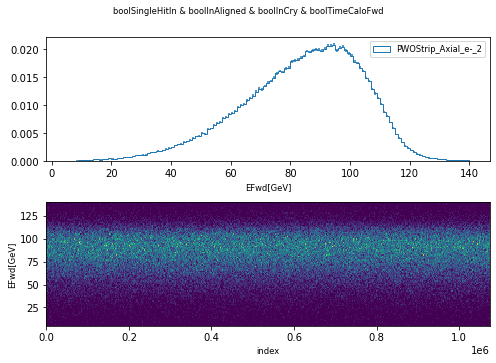

In [22]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = "energyFwd"  # figure name
xSize = 7  # horizontal figure size
ySize = 5  # vertical figure size
binSize = 1  # bin size - can't be set to None (needed for errorbars)
xRange = [5, 140]  # plot range - [min, max] or None (for automatic definition for each typeRun value separately)
lsBool = ["boolSingleHitIn", "boolInAligned", "boolInCry", "boolTimeCaloFwd"]  # list of booleans (available in df) to be applied -- selection on typeRun applied automatically (if using cuts on crystal, consider including input single hit cond.)
bUseEpoch = False  # if True (False) the epoch (automatic event index) is used -- only if epoch in df, otherwise event index anyway
bLog = False  # if True (False), log (lin) scale on y/z in 1d/2d plots

###############
if boolPlotLoc & boolPlotGlob & any(bEFwd.values()):
    outData = plot_energyRuns(df, "Fwd", binSize, bEFwd, xRange, bEpoch, bUseEpoch, lsBool, bLog, outData, pal2d, units, xSize, ySize, figName, bPlotSave)  # forward calo. energy
    
# outData is updated with bin-by-bin spectra values -- entries name format: "EFwd_typeRun_histo"

### **output data**

In [23]:
# output dictionary outData saved as in ./out_data/outData.pickle
globals().update(outData)
saveOutData(globals())  # function in .modules
print("--")

########
# to open the Pickle file importing the anaKrys modules: 
#    outData = readOutData()  # function in .modules

saving output dictionary outData to ./out_data/outData.pickle, with 17 entries
--


---

## **whiteboard**

---

**stopping chronometer**

In [24]:
tStop = datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp())  # stop chronometer
tStopPrint = tStop.strftime("%Y-%m-%d %H:%M:%S GMT")
dt = tStop - tStart
dtPrint = str(dt - datetime.timedelta(microseconds=dt.microseconds))
print("stop @ %s" % tStopPrint)
print("total elapsed time (from last restart -- %s): %s" % (tStartPrint, dtPrint))
outData["execTime"] = [tStart, tStop, dt]
print("execution time info added to outData[""execTime""] -- start, stop, delta\n--")

stop @ 2022-06-08 17:54:16 GMT
total elapsed time (from last restart -- 2022-06-08 17:52:40 GMT): 0:01:35
execution time info added to outData[execTime] -- start, stop, delta
--


**(re)writing output data**

In [25]:
# this is done to add the execTime entry, together with any other entry from the whiteboard
globals().update(outData)
saveOutData(globals())  # function in .modules
print("--")

########
# to open the Pickle file importing the anaKrys modules: 
#    outData = readOutData()  # function in .modules

saving output dictionary outData to ./out_data/outData.pickle, with 18 entries
--
